Enter the dimension of the maze: 11


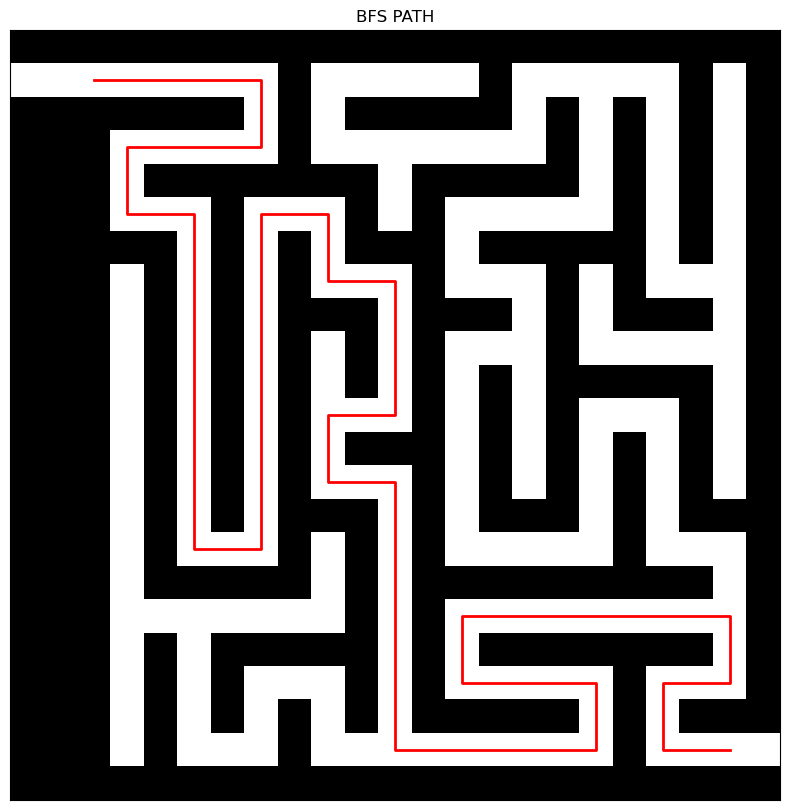

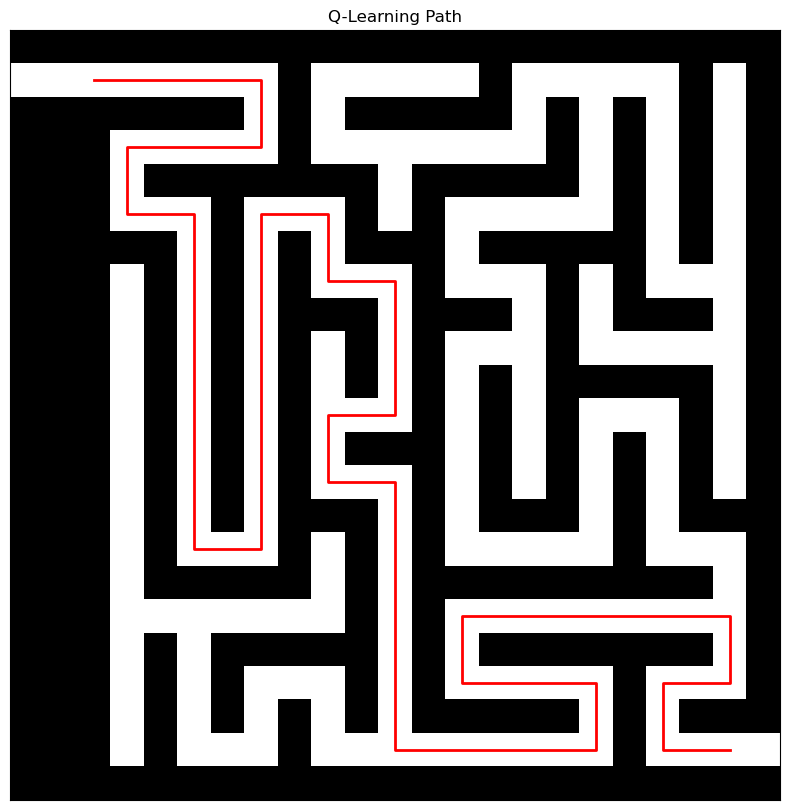

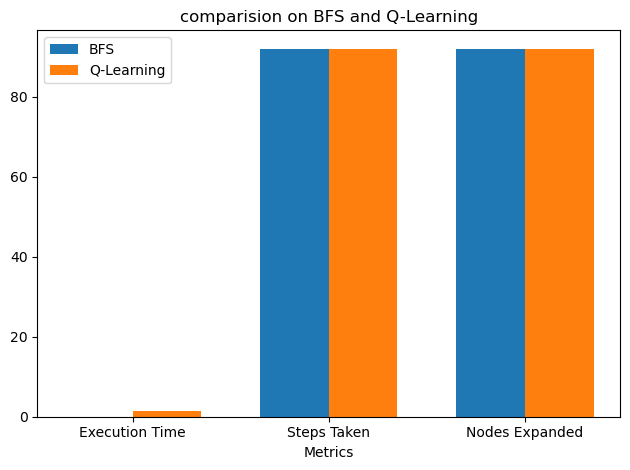

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from queue import Queue
def create_maze(dim):
    """create a maze with a given dimension.
    Paramerters: dim(int):The dimension of the maze.
    Returns: np.ndarray:A 2D numpy array representing the maze."""
    maze=np.ones((dim*2+1,dim*2+1))
    
    #Define the starting point
    x,y=(0,0)
    maze[2*x+1,2*y+1]=0
    #Initialize the stack with the starting point
    stack=[(x,y)]
    while len(stack)>0:
        x,y=stack[-1]
        #Define possible directions
        directions=[(0,1),(1,0),(0,-1),(-1,0)]
        random.shuffle(directions)
        
        for dx,dy in directions:
            nx,ny=x+dx,y+dy
            if nx>=0 and ny>0 and nx<dim and ny<dim and maze[2*nx+1,2*ny+1]==1:
                maze[2*nx+1,2*ny+1]=0
                maze[2*x+1+dx,2*y+1+dy]=0
                stack.append((nx,ny))
                break
        else:
            stack.pop()
        #create an entrance and an exit
    maze[1,0]=0
    maze[-2,-1]=0
    return maze
def bfs_find_path(maze):
    "Finding the shortest path in the maze by using BFS."
    directions=[(0,1),(1,0),(0,-1),(-1,0)]
    start=(1,1)
    end=(maze.shape[0]-2,maze.shape[1]-2)
    visited=np.zeros_like(maze,dtype=bool)
    visited[start]=True
    queue= Queue()
    queue.put((start,[]))
    while not queue.empty():
        (node,path)=queue.get()
        for dx,dy in directions:
            next_node=(node[0]+dx,node[1]+dy)
            if next_node ==end:
                return path+[next_node]
            if(0<=next_node[0]<maze.shape[0] and 0<=next_node[1]<maze.shape[1] and 
               maze[next_node]==0 and not visited[next_node]):
                visited[next_node]=True 
                queue.put((next_node,path +[next_node]))
    return[]
def q_learning_find_path(maze, start, end, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
  
    q_table = {}
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    def get_q(state, action):
        return q_table.get((state, action), 0.0)

    def update_q(state, action, reward, next_state):
        best_next_action = max(directions, key=lambda a: get_q(next_state, a))
        td_target = reward + gamma * get_q(next_state, best_next_action)
        td_delta = td_target - get_q(state, action)
        q_table[(state, action)] = get_q(state, action) + alpha * td_delta

    for _ in range(episodes):
        state = start
        while state != end:
            if random.random() < epsilon:
                action = random.choice(directions)
            else:
                action = max(directions, key=lambda a: get_q(state, a))
            
            next_state = (state[0] + action[0], state[1] + action[1])
            if (0 <= next_state[0] < maze.shape[0] and 0 <= next_state[1] < maze.shape[1] and maze[next_state] == 0):
                reward = -1
                if next_state == end:
                    reward = 0
                update_q(state, action, reward, next_state)
                state = next_state
            else:
                reward = -1
                update_q(state, action, reward, state)

    # Extract path using learned Q-values
    path = []
    state = start
    while state != end:
        action = max(directions, key=lambda a: get_q(state, a))
        next_state = (state[0] + action[0], state[1] + action[1])
        if next_state != state:
            path.append(next_state)
        state = next_state
    return path
 
def draw_maze(maze,path=None,title="Maze"):
    "Visalizes the maze and the path taken."
    fig,ax=plt.subplots(figsize=(10,10))
    ax.imshow(maze,cmap=plt.cm.binary,interpolation='nearest')
    if path:
        x_coords=[x[1] for x in path]
        y_coords=[y[0] for y in path]
        ax.plot(x_coords,y_coords,color='red',linewidth=2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.show()
def evaluate_algorithm(maze,algorithm):
    start_time=time.time()
    if algorithm ==bfs_find_path:
        path=algorithm(maze)
        nodes_expanded=len(path)
        steps=len(path)
    else:
        start=(1,1)
        end=(maze.shape[0]-2,maze.shape[1]-2)
        path=algorithm(maze,start,end)
        nodes_expanded=len(path)
        steps=len(path)
    execution_time=time.time()-start_time
    return path,execution_time,steps,nodes_expanded
def plot_comparison(results):
    labels=['Execution Time','Steps Taken','Nodes Expanded']
    bfs_metrics=[results['bfs']['execution_time'],results['bfs']['steps'],results['bfs']['nodes_expanded']]
    q_learning_metrics=[results['q_learning']['execution_time'],results['q_learning']['steps'],results['q_learning']['nodes_expanded']]
    x=np.arange(len(labels))
    width=0.35
    fig,ax=plt.subplots()
    rects1=ax.bar(x-width/2,bfs_metrics,width,label='BFS')
    rects2=ax.bar(x+width/2,q_learning_metrics,width,label='Q-Learning')
    ax.set_xlabel('Metrics')
    ax.set_title('comparision on BFS and Q-Learning')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()
if __name__=="__main__":
    dim=int(input("Enter the dimension of the maze: "))
    maze=create_maze(dim)
    #Evaluate BFS
    bfs_path,bfs_time,bfs_steps,bfs_nodes_expanded=evaluate_algorithm(maze,bfs_find_path)
    draw_maze(maze,bfs_path,title="BFS PATH")
    #Evaluate Q-Learning
    q_learning_path,q_learning_time,q_learning_steps,q_learning_nodes_expanded=evaluate_algorithm(maze,q_learning_find_path)
    draw_maze(maze,q_learning_path,title='Q-Learning Path')
    
    results={'bfs':{
                    'execution_time':bfs_time,
                    'steps':bfs_steps,
                    'nodes_expanded':bfs_nodes_expanded},
            'q_learning': {
            'execution_time': q_learning_time,
            'steps': q_learning_steps,
            'nodes_expanded': q_learning_nodes_expanded
            }
    }
    plot_comparison(results)